# Обучение ESRGAN-модели для увеличения детализации спутниковых снимков

Импортируем требуемые зависимости

In [1]:
from PIL import Image

import numpy as np
from tqdm import tqdm

import cv2
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg19

Объявим класс датасета, картинки ресайзим "на лету", на диске только высокое разрешение

In [2]:
class SRDataset(Dataset):
    def __init__(self, root_dir, lowres_transform, highres_transform, both_transform=None):
        super(SRDataset, self).__init__()

        self.root_dir = root_dir

        self.lowres_transform = lowres_transform
        self.highres_transform = highres_transform
        self.both_transform = both_transform

        self.list_of_files = [f for f in os.listdir(os.path.join(root_dir)) if f.endswith('.png')]

    def __len__(self):
        return len(self.list_of_files)

    def __getitem__(self, index):
        image = np.array(Image.open(os.path.join(self.root_dir, self.list_of_files[index])))
        image = image[:, :, :3]
        if self.both_transform:
            image = self.both_transform(image)
        low_res_image = self.lowres_transform(image)
        high_res_image = self.highres_transform(image)

        return low_res_image, high_res_image

Объявим строительные блоки модели

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))

In [4]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_channels, in_channels, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))

In [5]:
class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels*i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <=3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)

        return self.residual_beta * out + x

In [6]:
class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x

Объявим классы генератора и дискриминатора

In [98]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels),
            UpsampleBlock(num_channels)
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=True)
        )

    def forward(self, x):
        initial = self.initial(x)
        out = self.residuals(initial)
        out = self.conv(out) + initial
        out = self.upsamples(out)
        out = self.final(out)
        return out

In [99]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=(64, 64, 128, 128, 256, 256, 512, 512)):
        super().__init__()

        self.in_channels = in_channels
        self.features = list(features)

        blocks = []

        for idx, feature in enumerate(self.features):
            blocks.append(
                ConvBlock(
                    in_channels=in_channels,
                    out_channels=feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_act=True
                )
            )
            in_channels=feature

        self.blocks = nn.Sequential(*blocks)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(in_features=512*6*6, out_features=1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=1024, out_features=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = self.blocks(x)
        out = self.classifier(features)
        # out = self.sigmoid(out)
        return out

In [100]:
def init_weights(model, scale=0.1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale



Объявим функции ошибок

In [103]:
class VGGLoss(nn.Module):
    def __init__(self, device):
        super().__init__()

        self.vgg = vgg19(pretrained=True).features[:35].eval().to(device)
        self.loss = nn.MSELoss()
        self.transform = torch.nn.functional.interpolate

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        torch.nn.functional.interpolate
        output = self.transform(output, mode='bilinear', size=(224, 224), align_corners=False)
        target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        vgg_input_features = self.vgg(output)
        vgg_target_features = self.vgg(target)
        loss = self.loss(vgg_input_features, vgg_target_features)

        return loss

In [104]:
class ESRGANLoss(nn.Module):
    def __init__(self, l1_weight=1e-2, vgg_weight=1, device='cpu'):
        super().__init__()

        self.vgg_criterion = VGGLoss(device)
        self.l1_criterion = nn.L1Loss().to(device)
        self.l1_weight = l1_weight

    def forward(self, output, target):
        vgg_loss = self.vgg_criterion(output, target)
        l1_loss = self.l1_criterion(output, target)

        loss = vgg_loss + self.l1_weight * l1_loss
        return loss

In [105]:
def gradient_penalty(critic, real, fake, device):
    batch_size, channels, height, width = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, channels, height, width).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

Инициализируем гиперпараметры, загрузчики и обучаем модель

In [106]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [125]:
lr = 1e-4
num_epochs = 5
batch_size = 8
lambda_gp = 10
num_workers = 1

In [126]:
high_res = 128
low_res = 32
num_channels = 3

In [127]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [128]:
highres_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res, high_res), antialias=True),
    transforms.ToTensor(),
])

lowres_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res, low_res), antialias=True),
    transforms.ToTensor(),
])

both_transforms = transforms.Compose([
]);

In [129]:
train_dataset = SRDataset(
    root_dir = './images/res_128/',
    lowres_transform = lowres_transform,
    highres_transform = highres_transform,
    #both_transform = both_transforms
)

val_dataset = SRDataset(
    root_dir = './images/res_128_test/',
    lowres_transform = lowres_transform,
    highres_transform = highres_transform,
    #both_transform = both_transforms
)

In [130]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

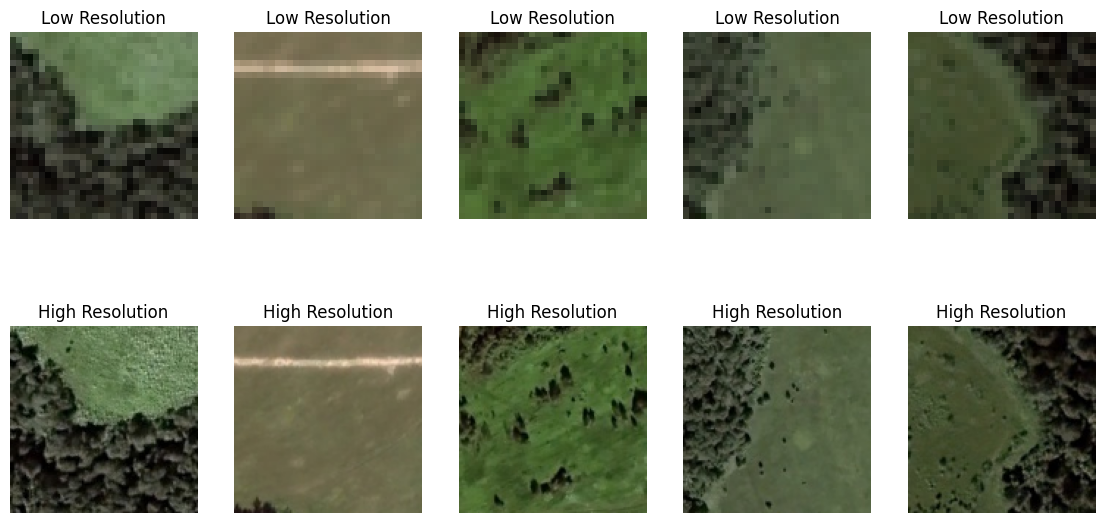

In [131]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7))

for i, (low_res, high_res) in enumerate(val_loader):
    if i >= 5:
        plt.show()
        break

    axes[0, i].imshow(low_res[0].permute(1, 2, 0))
    axes[0, i].set_title("Low Resolution")
    axes[0, i].axis('off')

    axes[1, i].imshow(high_res[0].permute(1, 2, 0))
    axes[1, i].set_title("High Resolution")
    axes[1, i].axis('off')

In [132]:
generator = Generator(in_channels=num_channels, num_blocks=23).to(device)
discriminator = Discriminator(in_channels=num_channels).to(device)
init_weights(generator)
model = {
    'discriminator': discriminator,
    'generator': generator
}

In [133]:
#generator.load_state_dict(torch.load('generator_32_to_128'))

In [134]:
optimizer_generator = torch.optim.Adam(model['generator'].parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_discriminator = torch.optim.Adam(model['discriminator'].parameters(), lr=lr, betas=(0.0, 0.9))
optimizer = {
    'discriminator': optimizer_discriminator,
    'generator': optimizer_generator
}

In [135]:
criterion_generator = ESRGANLoss(l1_weight=1e-2,device=device)
criterion_discriminator = nn.BCELoss().to(device)
criterion = {
    'discriminator': criterion_discriminator,
    'generator': criterion_generator
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [136]:
generator_scaler = torch.cuda.amp.GradScaler()
discriminator_scaler = torch.cuda.amp.GradScaler()

In [137]:
def plot_examples(low_res_folder, gen, device):
    files = os.listdir(low_res_folder)

    gen.eval()
    for file in files:
        image = Image.open("test_images/" + file)
        with torch.no_grad():
            upscaled_img = gen(
                config.test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(device)
            )
        save_image(upscaled_img * 0.5 + 0.5, f"saved/{file}")
    gen.train()

In [138]:
def train(
    loader,
    disc,
    gen,
    opt_gen,
    opt_disc,
    l1,
    vgg_loss,
    g_scaler,
    d_scaler,
    tb_step,

    num_epochs=10,
    device = 'cpu'
):
    for iteration in range(num_epochs):
        loop = tqdm(loader, leave=True)

        for idx, (low_res, high_res) in enumerate(loop):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            with torch.cuda.amp.autocast():
                fake = gen(low_res)
                critic_real = disc(high_res)
                critic_fake = disc(fake.detach())
                gp = gradient_penalty(disc, high_res, fake, device=device)
                loss_critic = (
                    -(torch.mean(critic_real) - torch.mean(critic_fake))
                    + lambda_gp * gp
                )

            opt_disc.zero_grad()
            d_scaler.scale(loss_critic).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()

            # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            with torch.cuda.amp.autocast():
                l1_loss = 1e-2 * l1(fake, high_res)
                adversarial_loss = 5e-3 * -torch.mean(disc(fake))
                loss_for_vgg = vgg_loss(fake, high_res)
                gen_loss = loss_for_vgg + adversarial_loss# + l1_loss

            opt_gen.zero_grad()
            g_scaler.scale(gen_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()
            tb_step += 1

            loop.set_postfix(
                epoch=str(iteration)+"/"+str(num_epochs),
                gp=gp.item(),
                critic=loss_critic.item(),
                l1=l1_loss.item(),
                vgg=loss_for_vgg.item(),
                adversarial=adversarial_loss.item(),
            )

In [139]:
tb_step = train(
    loader = train_loader,
    disc = model["discriminator"],
    gen = model['generator'],
    opt_gen = optimizer['generator'],
    opt_disc = optimizer['discriminator'],
    l1 = nn.L1Loss(),
    vgg_loss = VGGLoss(device),
    g_scaler = generator_scaler,
    d_scaler = discriminator_scaler,
    tb_step = 0,
    device = device,
    num_epochs = 5
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2284/2284 [11:16<00:00,  3.38it/s, adversarial=-.0131, critic=-7.08, epoch=4/5, gp=0.162, l1=0.000388, vgg=0.314]   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


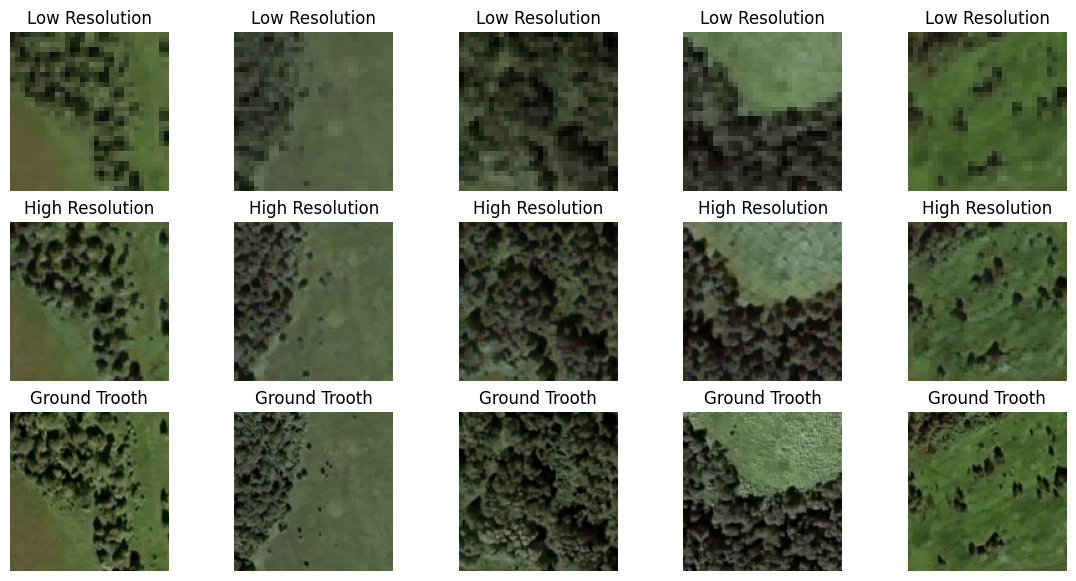

In [140]:
fig, axes = plt.subplots(3, 5, figsize=(14, 7))

for i, (low_res, high_res) in enumerate(val_loader):
    if i >= 5:
        plt.show()
        break

    axes[0, i].imshow(low_res[0].permute(1, 2, 0))
    axes[0, i].set_title("Low Resolution")
    axes[0, i].axis('off')

    low_res = low_res.to(device)
    high_res = high_res
    fake_high_res = model['generator'](low_res)
    fake_high_res = fake_high_res.to('cpu').detach()

    axes[1, i].imshow(fake_high_res[0].permute(1, 2, 0))
    axes[1, i].set_title("High Resolution")
    axes[1, i].axis('off')
    
    axes[2, i].imshow(high_res[0].permute(1, 2, 0))
    axes[2, i].set_title("Ground Trooth")
    axes[2, i].axis('off')

In [141]:
torch.save(generator.state_dict(), 'generator_32_to_128')